In [1]:
import time
import numpy as np
import tensorflow as tf
import random
from collections import Counter

In [2]:
text = []
with open('corpus_0307_1.txt','r') as f:
    for line in f.readlines():
        line = line.strip('\n')
        text.extend(line.split(" "))
print(len(text))

5207259


In [18]:
words_count = Counter(text)
#print(words_count)
#print(words_count)
words = [w for w in text if words_count[w]>=5 and w!='']
print(set(words))

{'superinterfaces', 'variableModifier', 'packageOrTypeName', 'wildcardBounds', 'switchStatement', 'statementNoShortIf', 'fieldAccess', 'interfaceTypeList', 'fieldModifier', 'dimExprs', 'enhancedForStatement', 'classMemberDeclaration', 'dims', 'labeledStatement', 'elementValueArrayInitializer', 'castExpression', 'inferredFormalParameterList', 'typeArgumentsOrDiamond', 'exceptionTypeList', 'classBody', 'variableInitializer', 'arrayCreationExpression', 'finally_', 'methodHeader', 'classOrInterfaceType', 'tryStatement', 'methodInvocation_lf_primary', 'dimExpr', 'formalParameter', 'classType_lf_classOrInterfaceType', 'emptyStatement', 'markerAnnotation', 'ambiguousName', 'classBodyDeclaration', 'localVariableDeclaration', 'methodInvocation_lfno_primary', 'classInstanceCreationExpression', 'block', 'assignmentOperator', 'floatingPointType', 'result', 'postfixExpression', 'numericType', 'switchLabel', 'constructorDeclaration', 'methodModifier', 'expression', 'classType', 'typeArguments', 'typ

In [19]:
vocab_dict = set(words)
vocab_to_int = {w:c for c,w in enumerate(vocab_dict)}
int_to_vocab = {c:w for c,w in enumerate(vocab_dict)}
print(vocab_to_int)
print("total words: {}".format(len(words)))
print("unique words: {}".format(len(vocab_dict)))
int_words = [vocab_to_int[w] for w in words]
train_words = int_words

{'superinterfaces': 0, 'variableModifier': 1, 'packageOrTypeName': 2, 'wildcardBounds': 3, 'switchStatement': 4, 'statementNoShortIf': 5, 'fieldAccess': 6, 'interfaceTypeList': 7, 'fieldModifier': 8, 'dimExprs': 9, 'enhancedForStatement': 10, 'classMemberDeclaration': 11, 'dims': 12, 'labeledStatement': 13, 'elementValueArrayInitializer': 14, 'castExpression': 15, 'inferredFormalParameterList': 16, 'typeArgumentsOrDiamond': 17, 'exceptionTypeList': 18, 'classBody': 19, 'variableInitializer': 20, 'arrayCreationExpression': 21, 'finally_': 22, 'methodHeader': 23, 'classOrInterfaceType': 24, 'tryStatement': 25, 'methodInvocation_lf_primary': 26, 'dimExpr': 27, 'formalParameter': 28, 'classType_lf_classOrInterfaceType': 29, 'emptyStatement': 30, 'markerAnnotation': 31, 'ambiguousName': 32, 'classBodyDeclaration': 33, 'localVariableDeclaration': 34, 'methodInvocation_lfno_primary': 35, 'classInstanceCreationExpression': 36, 'block': 37, 'assignmentOperator': 38, 'floatingPointType': 39, 're

In [76]:
#t =1e-5
#threshold = 0.95

#int_words_counts = Counter(int_words)
#total_count = len(int_words)
#words_freqs = {w: c/total_count for w,c in int_words_counts.items()}
#prob_drop = {w: 1-np.sqrt(t/words_freqs[w]) for w in int_words_counts}
#train_words = [w for w in int_words if prob_drop[w] < threshold]
#print(len(set(train_words)))
#for idx in set(int_words):
#    if idx not in set(train_words):
#        print(int_to_vocab[idx],":",words_count[int_to_vocab[idx]])

In [77]:
def get_target(words,idx,window_size = 5):
    target_window = np.random.randint(1,window_size+1)
    start_idx = idx - target_window if (idx - target_window) > 0 else 0
    end_idx = idx + target_window
    targets_words = set(words[start_idx:idx]+words[idx+1:end_idx+1])
    return list(targets_words)

In [86]:
def get_batches(words,batch_size,window_size=5): #batch 生成器
    batch_num = len(words) // batch_size        #返回值形式为一个batch_size大小的句子中，所有的样本
    
    words = words[:batch_num*batch_size]
    for idx in range(0,len(words),batch_size):
        x,y = [],[]
        batch = words[idx:idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_target(batch,i,window_size)
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x,y

In [87]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32,shape=[None],name='inputs')
    labels = tf.placeholder(tf.int32,shape=[None,None],name='labels')

In [88]:
vocab_size = len(int_to_vocab)
embedding_size = 64 # 嵌入维度

In [89]:
with train_graph.as_default():
    #嵌入权重矩阵
    embedding = tf.Variable(tf.random_uniform([vocab_size,embedding_size],-1,1))
    embed = tf.nn.embedding_lookup(embedding,inputs)

In [90]:
n_sampled = 100

with train_graph.as_default():
    weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    biases = tf.Variable(tf.zeros(vocab_size))
    
    # 计算negative sampling下的损失
    loss = tf.nn.sampled_softmax_loss(weights, biases, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [91]:
#validation
with train_graph.as_default():
    valid_examples = [vocab_to_int['whileStatement'],vocab_to_int['forStatement']]
    valid_size = len(valid_examples)
    # 验证单词集
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    # 查找验证单词的词向量
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset) #查找验证集的向量
    # 计算余弦相似度
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))#矩阵乘法

In [95]:
epochs = 10
batch_size = 1000
window_size = 5

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
    for e in range(1,epochs+1):
        batches = get_batches(train_words,batch_size,window_size)
        start = time.time()
        
        for x,y in batches:
            feed = {inputs:x,
                    labels:np.array(y)[:,None]}
            train_loss,_ = sess.run([cost,optimizer],feed_dict=feed)
            loss+= train_loss
            
            if iteration % 1000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                    "Iteration: {}".format(iteration),
                    "Avg. Training loss: {:.4f}".format(loss/100),
                    "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
                
            if iteration % 10000 == 0:
                # 计算similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # 取最相似单词的前8个
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
        
                
    save_path = saver.save(sess, "word2vec.ckpt")
    embed_mat = sess.run(embedding)
            
            

Epoch 1/10 Iteration: 1000 Avg. Training loss: 29.1493 0.2501 sec/batch
Epoch 1/10 Iteration: 2000 Avg. Training loss: 26.3221 0.2472 sec/batch
Epoch 1/10 Iteration: 3000 Avg. Training loss: 26.1845 0.2441 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 26.4329 0.2482 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 25.3479 0.2420 sec/batch
Epoch 2/10 Iteration: 6000 Avg. Training loss: 25.5833 0.1922 sec/batch
Epoch 2/10 Iteration: 7000 Avg. Training loss: 26.1297 0.2474 sec/batch
Epoch 2/10 Iteration: 8000 Avg. Training loss: 25.9184 0.2468 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 26.2308 0.2462 sec/batch
Epoch 2/10 Iteration: 10000 Avg. Training loss: 25.4314 0.2432 sec/batch
Nearest to [whileStatement]: ifThenElseStatement, ifThenStatement, forStatement, switchStatement, synchronizedStatement, assertStatement, labeledStatement, statementWithoutTrailingSubstatement,
Nearest to [forStatement]: basicForStatement, forInit, whileStatement, ifThenElseStat

In [ ]:
wordvec_dict = {}
for w,c in vocab_to_int.items():
    wordvec_dict[w] = embed_mat[c]
print(wordvec_dict)

import pickle as pkl
output = open('word_vector.pkl','wb')
pkl.dump(wordvec_dict,output)


In [25]:

import pickle
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
from mpld3 import plugins
pkl_file = open('word_vector.pkl','rb')
word_vectors = pickle.load(pkl_file)
#print(word_vectors)
word_vectors.pop('')

words_list = list(word_vectors.keys())
vector_list = list(word_vectors.values())
#print(words_list)
#print(vector_list)
x_y = TSNE(n_components=2).fit_transform(vector_list)
print(x_y)



[[  4.83872509e+00  -1.15896988e+00]
 [ -2.15072417e+00   3.53003097e+00]
 [ -3.94983530e+00   1.60805464e+00]
 [ -2.88369155e+00   6.30308151e-01]
 [  1.29916680e+00   9.82644796e-01]
 [  3.70569921e+00  -1.02324617e+00]
 [  1.11429656e+00   2.28040218e-02]
 [ -4.89004803e+00  -5.93147874e-01]
 [ -7.74913669e-01  -5.26541901e+00]
 [  6.04061365e+00   4.21941519e+00]
 [  3.80865073e+00  -5.09030533e+00]
 [ -1.60656512e+00  -5.85328150e+00]
 [  2.87361354e-01   9.19065094e+00]
 [  2.33294666e-01   1.84028244e+00]
 [ -3.63619864e-01   5.69872952e+00]
 [  4.57010794e+00  -5.33758020e+00]
 [  4.76560068e+00   1.92143774e+00]
 [  2.82725143e+00   1.40389279e-01]
 [  1.43391907e+00  -2.23194861e+00]
 [  2.35071135e+00   6.42735434e+00]
 [ -3.17414477e-02   6.53030396e-01]
 [ -2.11233944e-01  -1.11329103e+00]
 [  1.98629141e+00   1.25585544e+00]
 [  7.30633020e-01  -3.25003147e+00]
 [ -1.12079307e-01  -4.21510905e-01]
 [  9.49887186e-02  -4.96022081e+00]
 [  3.27928096e-01   9.25029564e+00]
 

TypeError: Object of type 'ndarray' is not JSON serializable

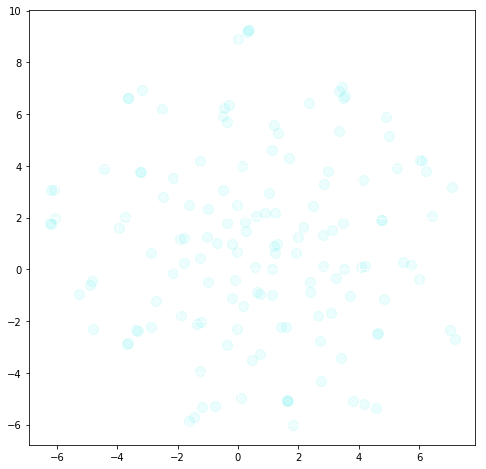

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
ax.grid(color='white', linestyle='solid')

num_words_to_plot = len(words_list)

scatter = ax.scatter(x_y[:num_words_to_plot, 0], x_y[:num_words_to_plot, 1], s = 100, c='#3EEEEE', alpha=0.1, cmap=plt.cm.jet)
labels = [int_to_vocab[i] for i in range(num_words_to_plot)]
plugins.connect(fig, plugins.PointLabelTooltip(scatter, labels))